# Covariates extension for CHRONOS


preliminaries

# Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import PowerTransformer

In [3]:
from utils.functions import *

# Dataset

In [4]:

path = 'air+quality'
df = pd.read_csv(path + '/AirQualityUCI.csv', na_values=-200, dayfirst=True, sep=';', decimal=',')
df = df.rename(columns={'Date': 'date', 'Time': 'time'})    
df.head()

date      time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  
0  13.6  48.9  0.7578  
1  13.3  47.7  0.7255  
2  11.9  54.0  0.7502  
3  11.0  60.0  0.7867  
4  11.2  59.6  0.7888

In [5]:
df.describe()

CO(GT)  PT08.S1(CO)     NMHC(GT)     C6H6(GT)  PT08.S2(NMHC)  \
count  7674.000000  8991.000000   914.000000  8991.000000    8991.000000   
mean      2.152750  1099.833166   218.811816    10.083105     939.153376   
std       1.453252   217.080037   204.459921     7.449820     266.831429   
min       0.100000   647.000000     7.000000     0.100000     383.000000   
25%       1.100000   937.000000    67.000000     4.400000     734.500000   
50%       1.800000  1063.000000   150.000000     8.200000     909.000000   
75%       2.900000  1231.000000   297.000000    14.000000    1116.000000   
max      11.900000  2040.000000  1189.000000    63.700000    2214.000000   

           NOx(GT)  PT08.S3(NOx)      NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
count  7718.000000   8991.000000  7715.000000   8991.000000  8991.000000   
mean    246.896735    835.493605   113.091251   1456.264598  1022.906128   
std     212.979168    256.817320    48.370108    346.206794   398.484288   
min       2.000000    322.000000     2.000000    551.000000   221.000000   
25%      98.000000    658.000000    78.000000   1227.000000   731.500000   
50%     180.000000    806.000000   109.000000   1463.000000   963.000000   
75%     326.000000    969.500000   142.000000   1674.000000  1273.500000   
max    1479.000000   2683.000000   340.000000   2775.000000  2523.000000   

                 T           RH           AH  
count  8991.000000  8991.000000  8991.000000  
mean     18.317829    49.234201     1.025530  
std       8.832116    17.316892     0.403813  
min      -1.900000     9.200000     0.184700  
25%      11.800000    35.800000     0.736800  
50%      17.800000    49.600000     0.995400  
75%      24.400000    62.500000     1.313700  
max      44.600000    88.700000     2.231000

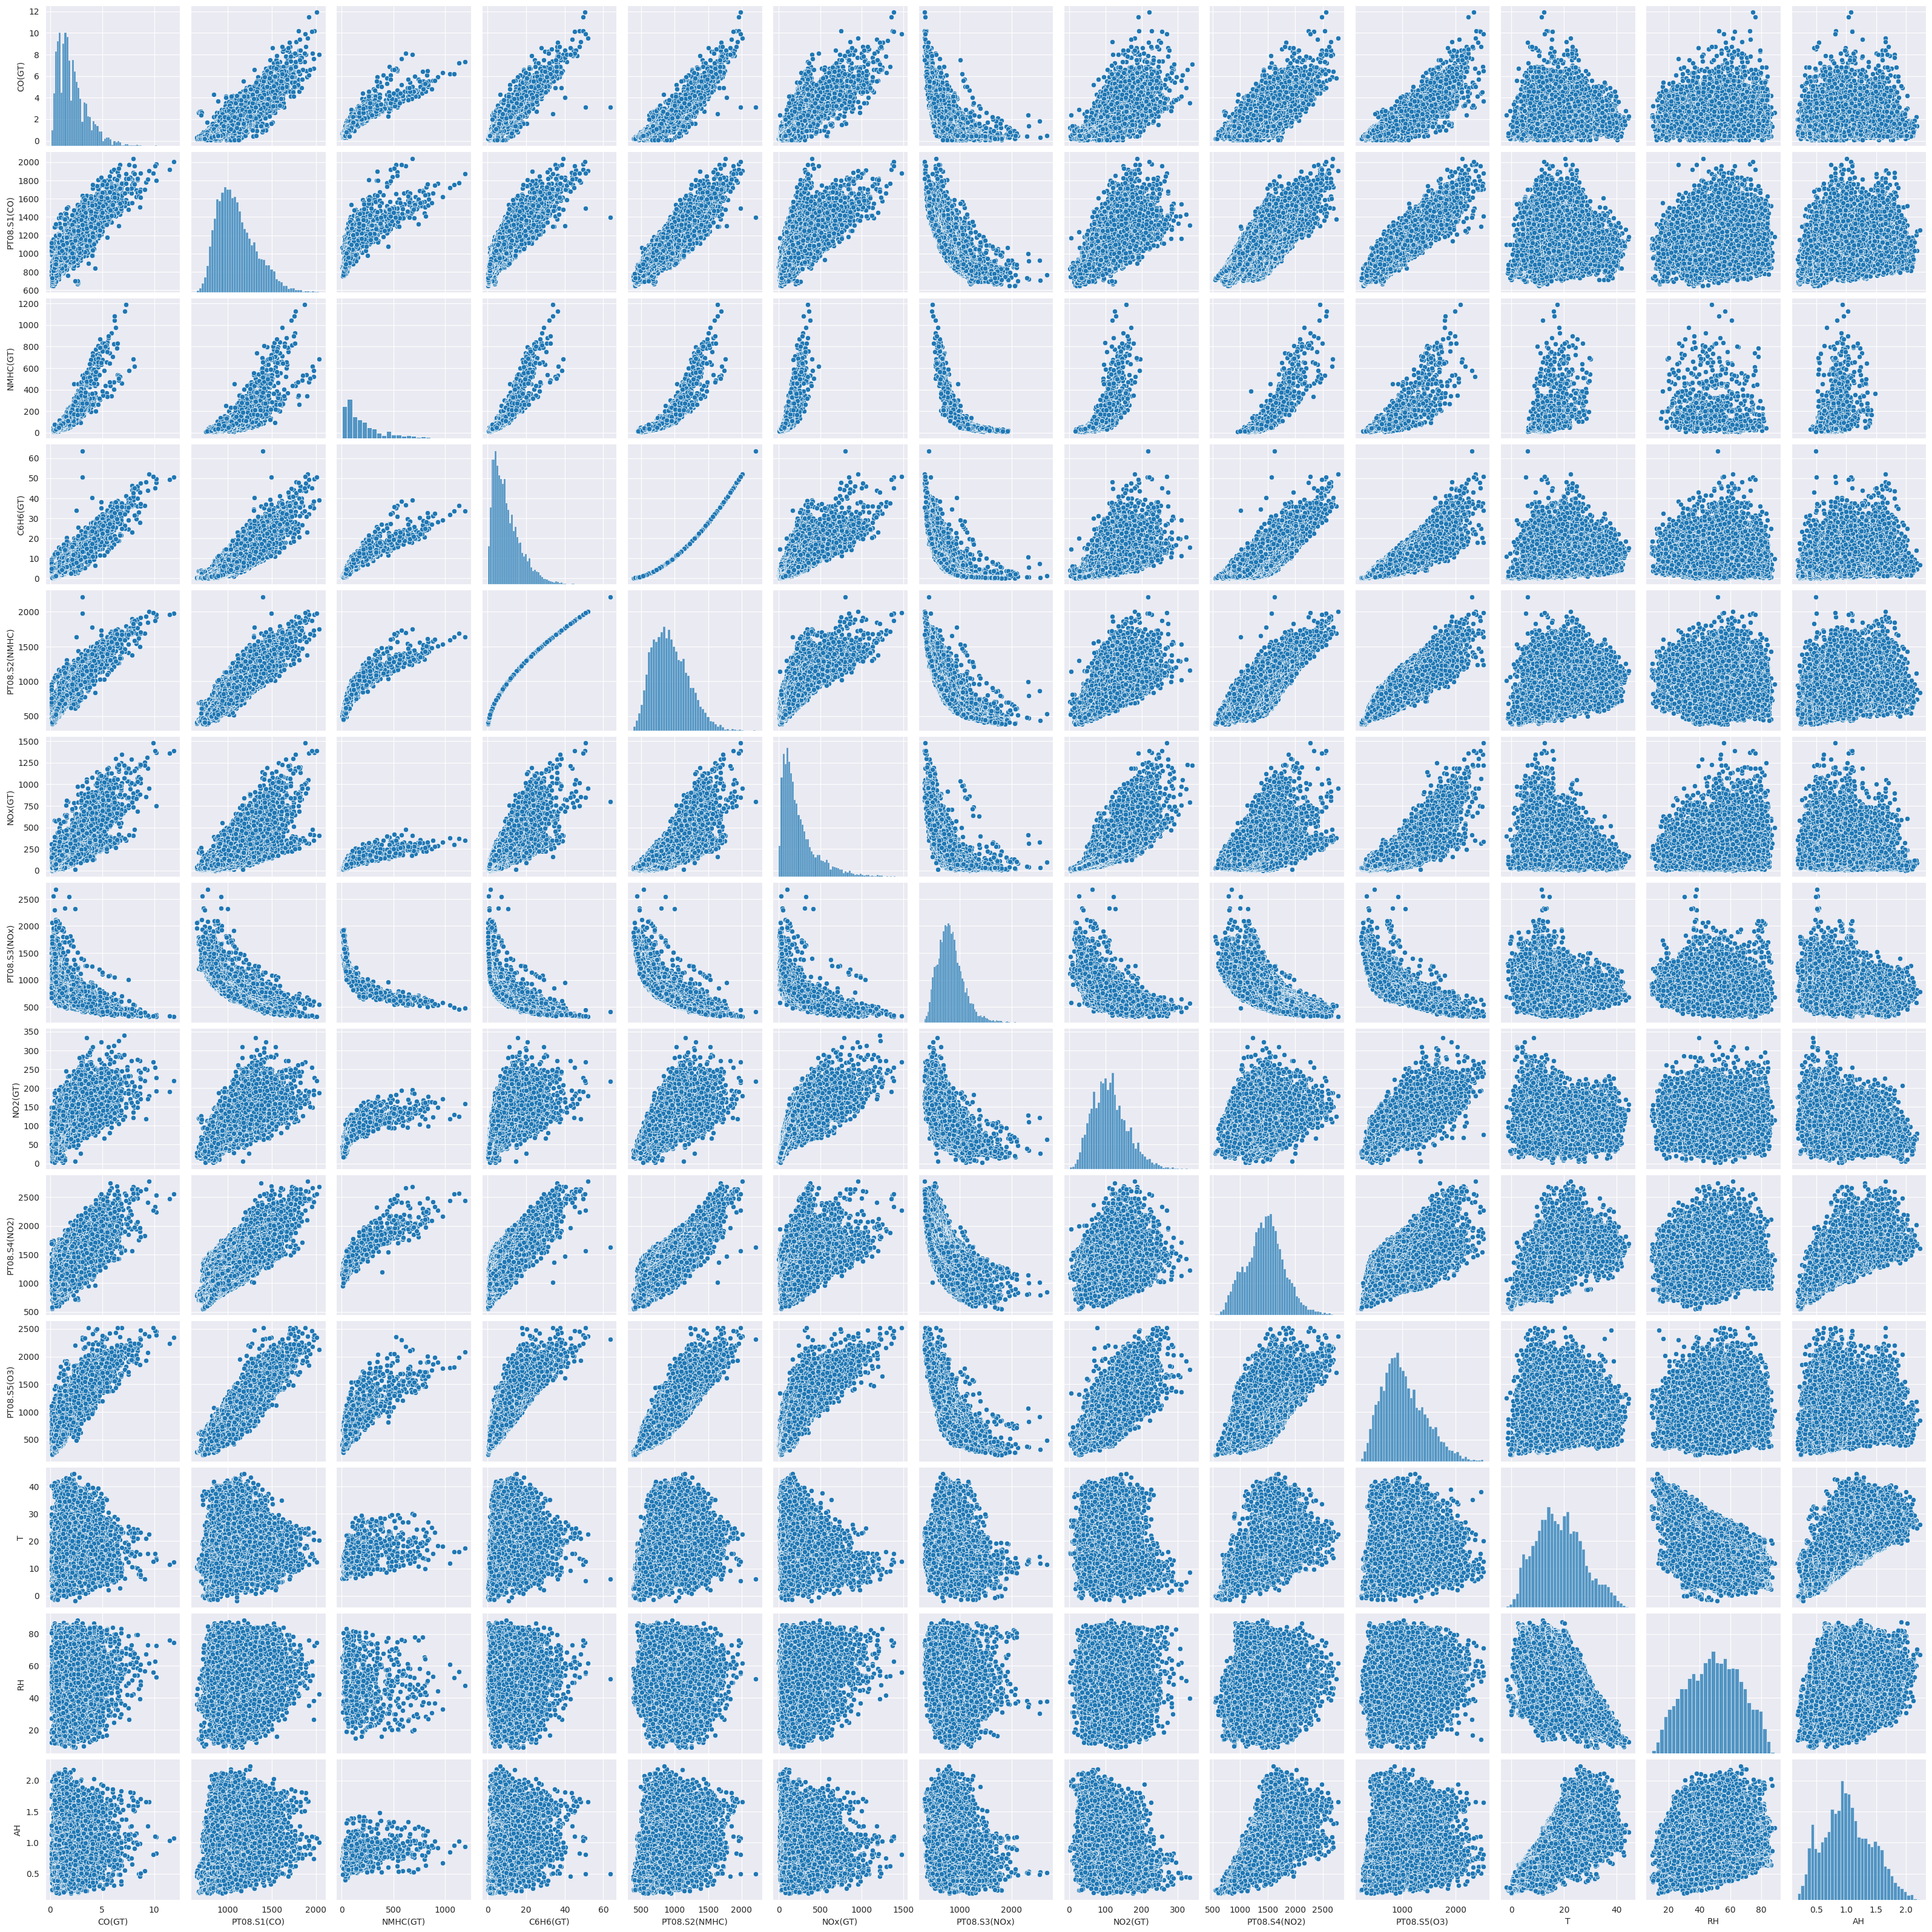

In [6]:
cols = list(df.columns[(df.columns != 'date') & (df.columns != 'time')])
sns.pairplot(df[cols]);

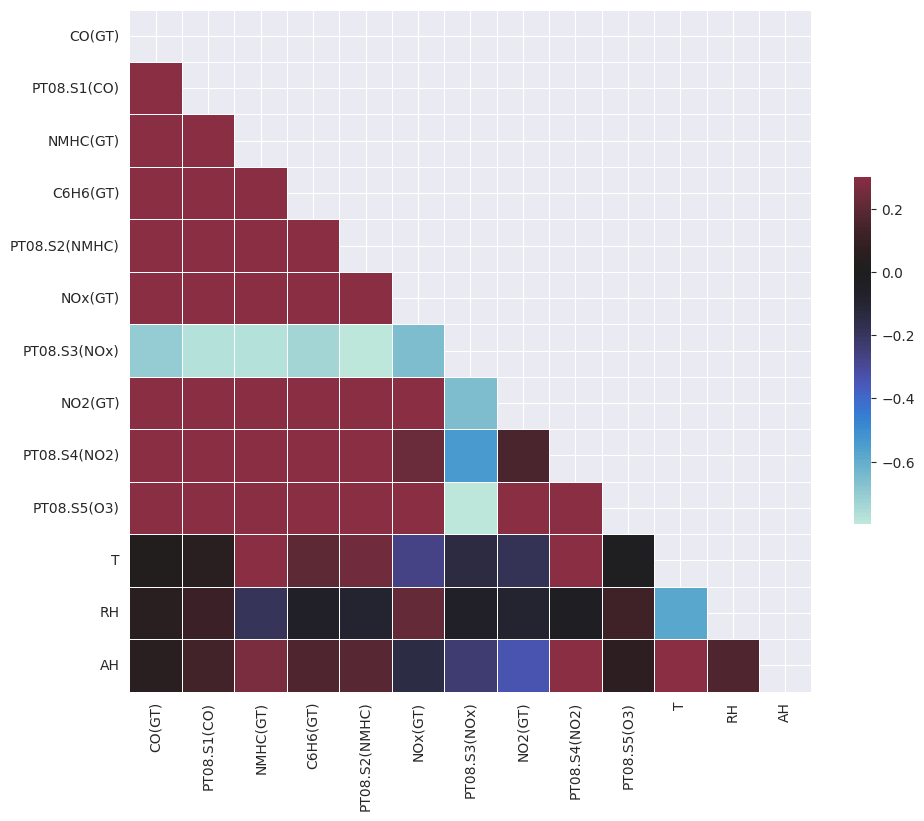

In [7]:
corr = df[cols].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Generate a custom diverging colormap
# cmap = sns.color_palette("Blues", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,  vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [8]:
df.isnull().sum() * 100 / df.shape[0]

date              0.000000
time              0.000000
CO(GT)           17.986534
PT08.S1(CO)       3.911510
NMHC(GT)         90.231912
C6H6(GT)          3.911510
PT08.S2(NMHC)     3.911510
NOx(GT)          17.516298
PT08.S3(NOx)      3.911510
NO2(GT)          17.548360
PT08.S4(NO2)      3.911510
PT08.S5(O3)       3.911510
T                 3.911510
RH                3.911510
AH                3.911510
dtype: float64

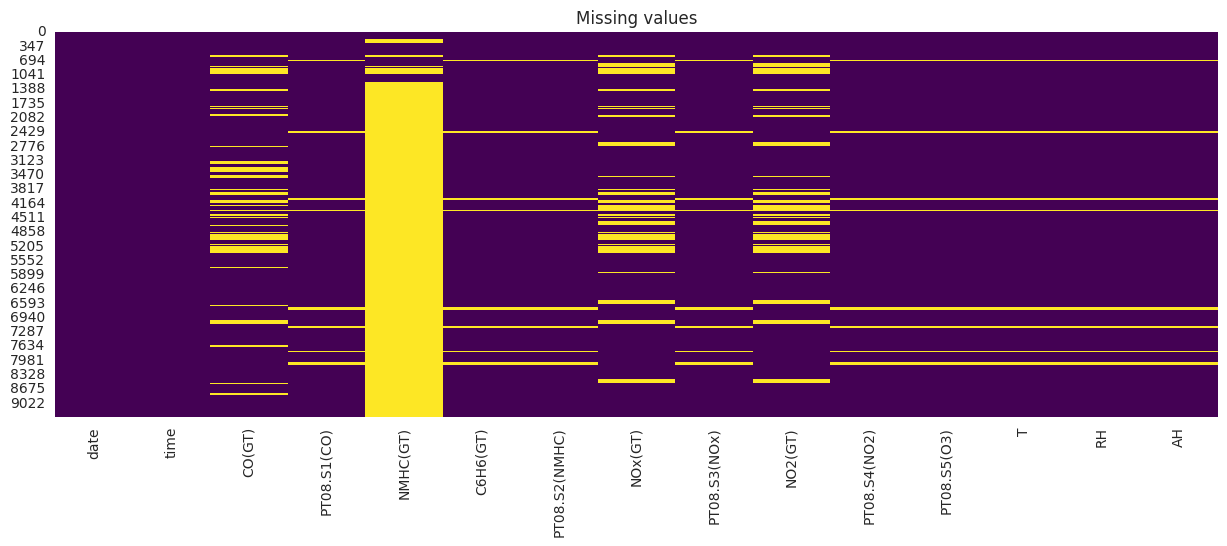

In [9]:
plt.figure(figsize=(15, 5))
plt.title('Missing values')
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()


In [10]:
df['time'] = df['time'].apply(lambda x: str(x).replace('.',':'))

In [11]:
df['timestamp'] = pd.to_datetime(df['date'] + ' ' + df['time'], dayfirst=True)
df = df.set_index('timestamp')
df = df.drop(columns=['date', 'time'])
df.head()

CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
timestamp                                                                     
2004-03-10 18:00:00     2.6       1360.0     150.0      11.9         1046.0   
2004-03-10 19:00:00     2.0       1292.0     112.0       9.4          955.0   
2004-03-10 20:00:00     2.2       1402.0      88.0       9.0          939.0   
2004-03-10 21:00:00     2.2       1376.0      80.0       9.2          948.0   
2004-03-10 22:00:00     1.6       1272.0      51.0       6.5          836.0   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
timestamp                                                           
2004-03-10 18:00:00    166.0        1056.0    113.0        1692.0   
2004-03-10 19:00:00    103.0        1174.0     92.0        1559.0   
2004-03-10 20:00:00    131.0        1140.0    114.0        1555.0   
2004-03-10 21:00:00    172.0        1092.0    122.0        1584.0   
2004-03-10 22:00:00    131.0        1205.0    116.0        1490.0   

                     PT08.S5(O3)     T    RH      AH  
timestamp                                             
2004-03-10 18:00:00       1268.0  13.6  48.9  0.7578  
2004-03-10 19:00:00        972.0  13.3  47.7  0.7255  
2004-03-10 20:00:00       1074.0  11.9  54.0  0.7502  
2004-03-10 21:00:00       1203.0  11.0  60.0  0.7867  
2004-03-10 22:00:00       1110.0  11.2  59.6  0.7888

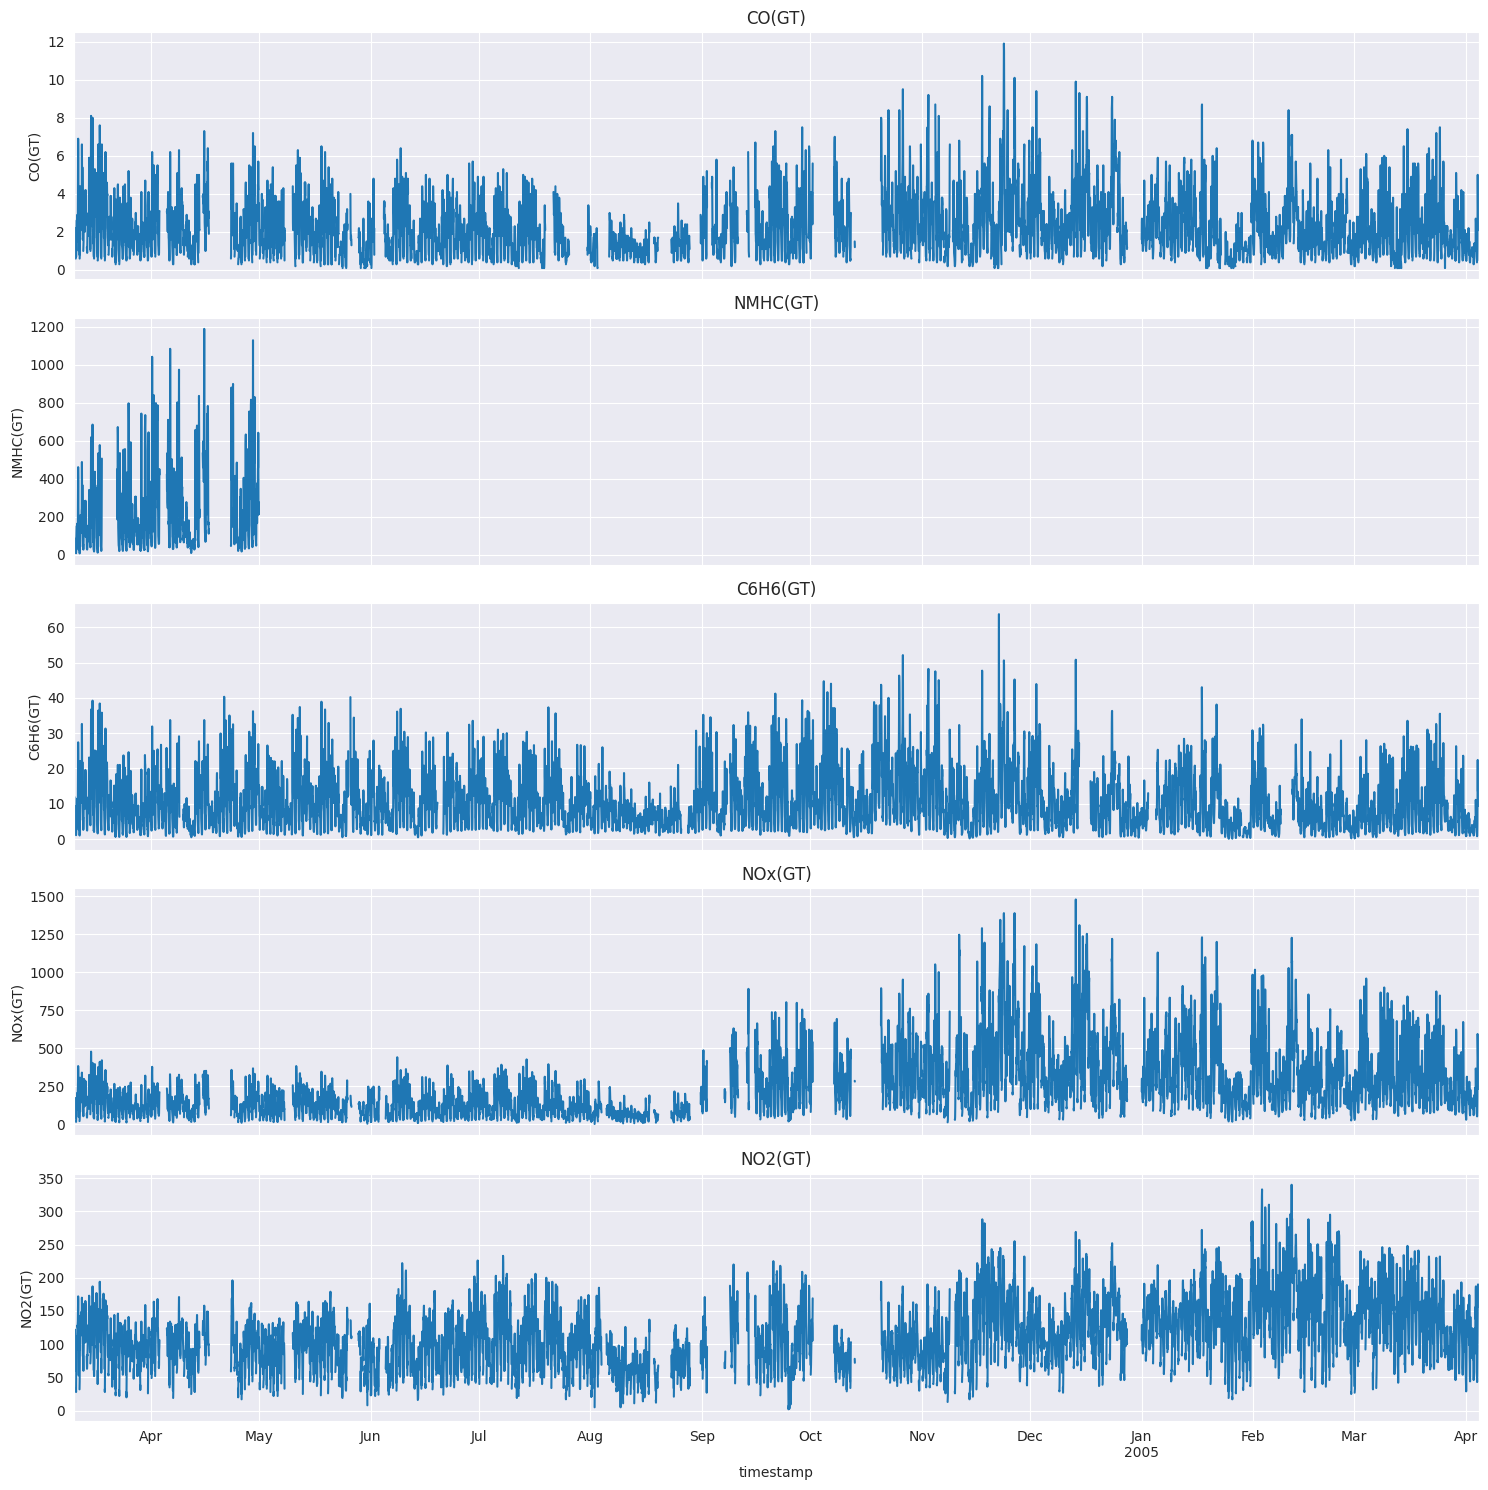

In [12]:
gt_cols = [col for col in df.columns if '(GT)' in col]

fig, axes = plt.subplots(len(gt_cols), 1, figsize=(15, 3 * len(gt_cols)), sharex=True)
for i, col in enumerate(gt_cols):
    df[col].plot(ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()

In [13]:
del df['NMHC(GT)']
gt_cols.remove('NMHC(GT)')
cols.remove('NMHC(GT)')
df2 = df[cols].copy()
df2[cols] = df2[cols].interpolate()
df2.isnull().sum() * 100 / df2.shape[0]

CO(GT)           0.0
PT08.S1(CO)      0.0
C6H6(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
dtype: float64

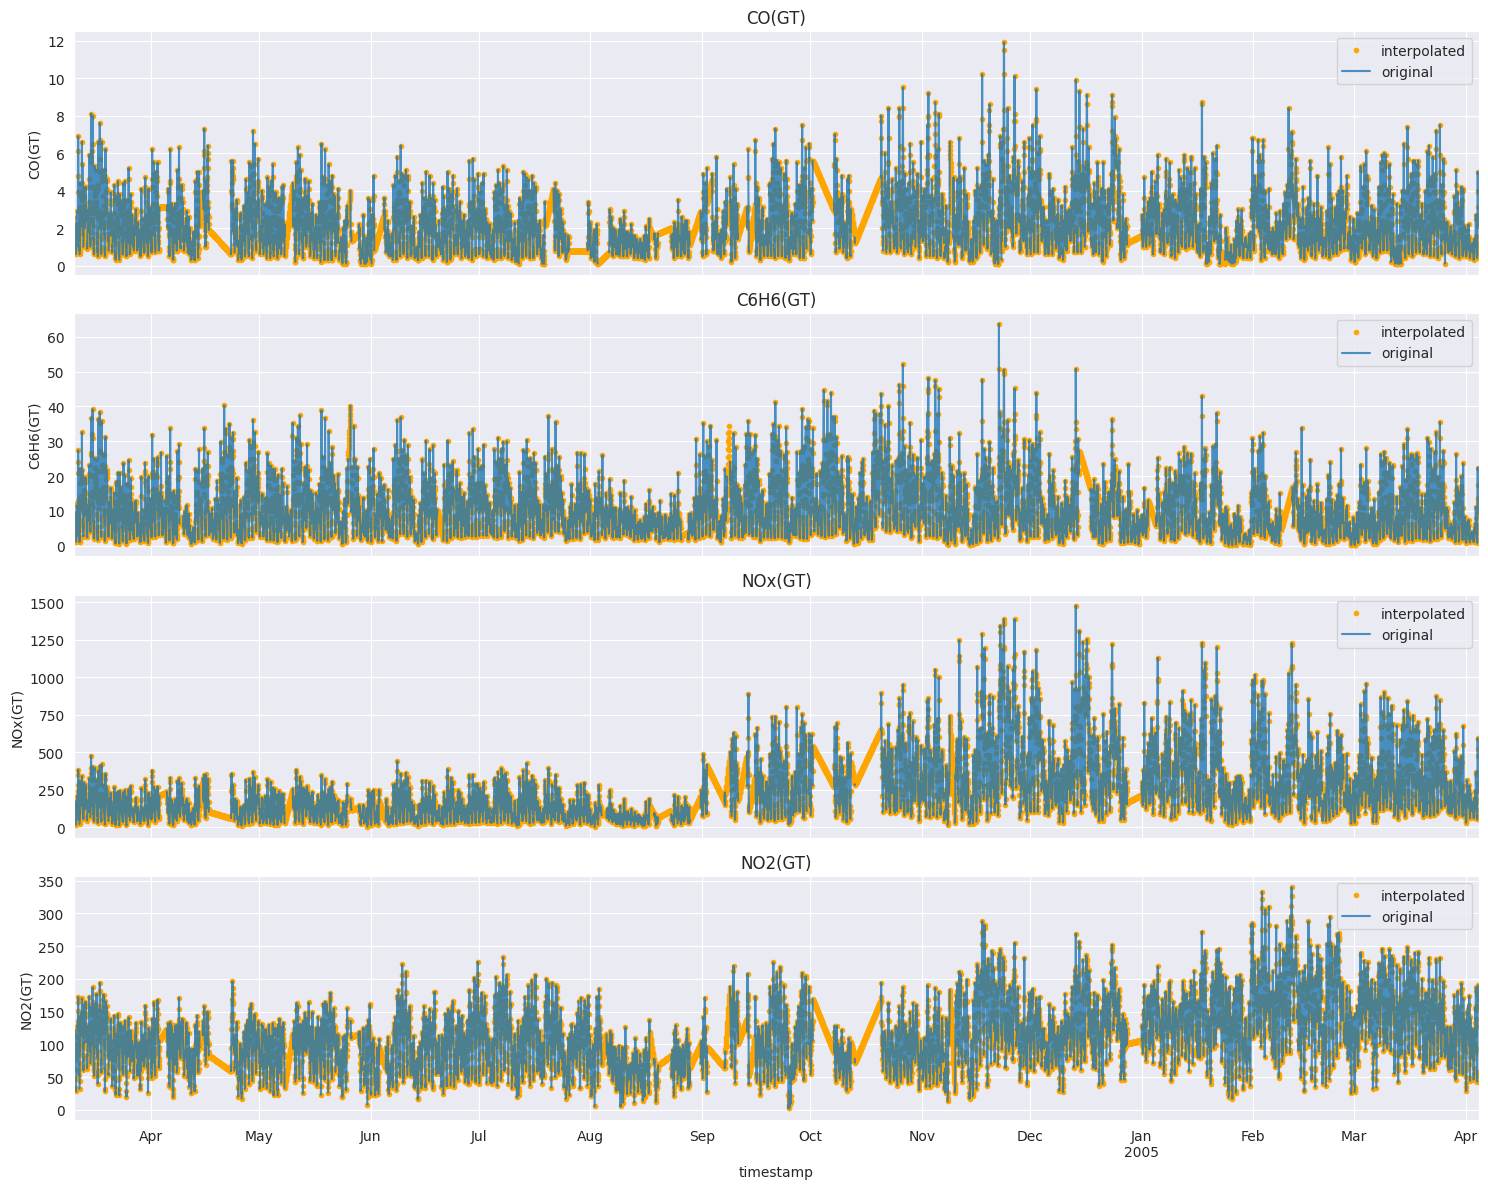

In [14]:
fig, axes = plt.subplots(len(gt_cols), 1, figsize=(15, 3 * len(gt_cols)), sharex=True)
for i, col in enumerate(gt_cols):
    df2[col].plot(ax=axes[i], label='interpolated', style='.', color='orange')
    df[col].plot(ax=axes[i], label='original', alpha=0.8, style='-')
    axes[i].set_title(col)
    axes[i].set_ylabel(col)
    axes[i].legend()
plt.tight_layout()
plt.show()

In [15]:

# Función para detectar intervalos faltantes (ajustada para timestamps)
def find_missing_intervals(series):
    is_na = series.isna()
    changes = [ j for j in range(1,len(is_na)) if is_na.iloc[j] != is_na.iloc[i-1]]

    # Convertir a lista de tuplas
    missing_intervals = [(df.index[changes[i-1]], df.index[changes[i]]) for i in range(1,len(changes),2)]
    return missing_intervals

def fill_gaps(attribute):

    # Cargar datos y extraer serie (ejemplo con índice datetime)
    serie = df[attribute].copy()

    # 1. Encontrar todos los bloques de NaN
    missing_intervals = find_missing_intervals(serie)

    # 2. Descomposición STL (usando interpolación lineal provisional)
    stl = STL(
        serie.interpolate('linear'),
        period=24,                # Ajustar si hay múltiples estacionalidades
        seasonal=13,              # Ventana más larga para estacionalidad
        robust=True               # Reduce impacto de outliers
    )
    res = stl.fit()


    # Transformación Yeo-Johnson para normalizar residuos
    transformer = PowerTransformer(method='yeo-johnson')
    resid_transformed = transformer.fit_transform(res.resid.dropna().values.reshape(-1, 1)).flatten()

    # Modelar residuos transformados
    model = SARIMAX(
        resid_transformed,
        order=(1, 0, 1),          # Reducir complejidad vs (1,1,1)
        seasonal_order=(0, 1, 1, 24),
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)

    for start, end in missing_intervals:
        gap_length = len(serie.loc[start:end])

        # 1. Simular residuos transformados
        simulated_transformed = model_fit.simulate(gap_length)

        # 2. Revertir transformación
        simulated_resid = transformer.inverse_transform(
            simulated_transformed.reshape(-1, 1)
        ).flatten()

        # 3. Imputación con límites físicos
        imputed = (
            res.seasonal.loc[start:end] +
            res.trend.loc[start:end] +
            simulated_resid*0.3
        )

        # 4. Forzar rango percentil 1%-99% histórico
        p10, p90 = serie.quantile([0.1, 0.90])
        imputed = np.clip(imputed, p10, p90)

        serie.loc[start:end] = imputed
    return serie

In [16]:
df3 = df.copy()
for i, col in enumerate(gt_cols):
    df3[col] = fill_gaps(col)

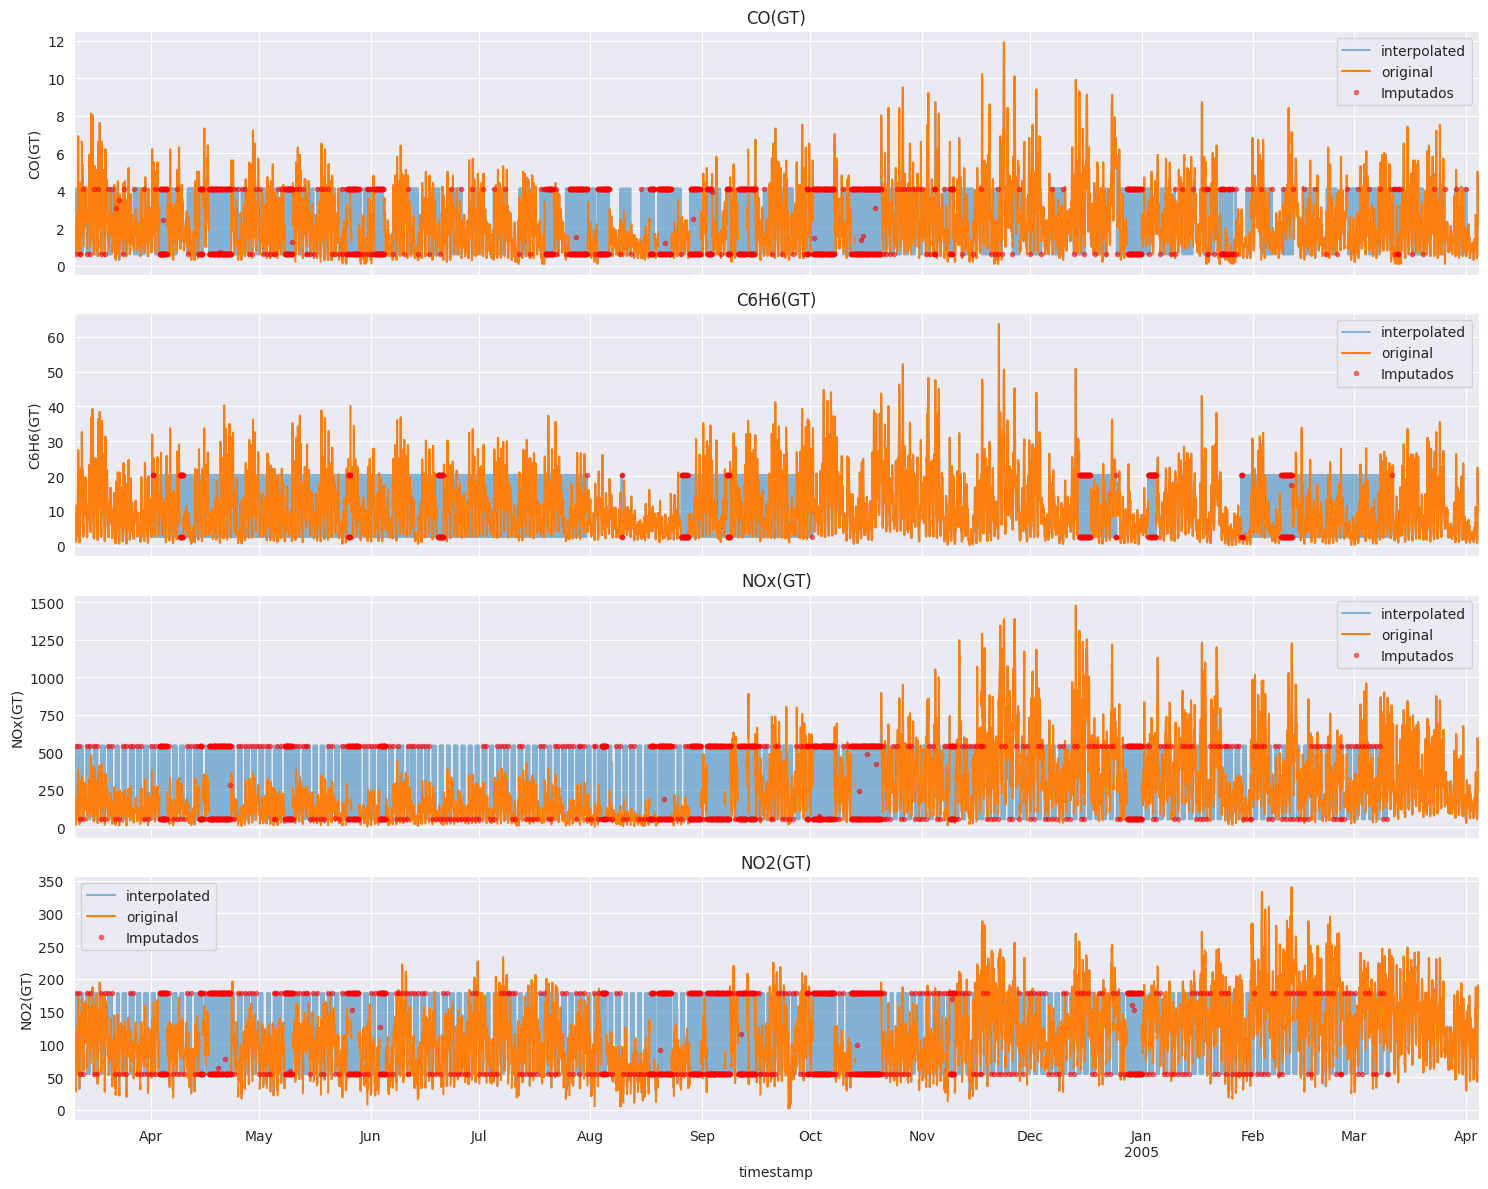

In [17]:

fig, axes = plt.subplots(len(gt_cols), 1, figsize=(15, 3 * len(gt_cols)), sharex=True)
for i, col in enumerate(gt_cols):
    original_nans = df[col].isna()
    df3[col].plot(ax=axes[i], label='interpolated', style='-', alpha=0.5)
    df[col].plot(ax=axes[i], label='original', alpha=1, style='-')
    df3.loc[original_nans,col].plot(ax=axes[i], label='Imputados', style='r.', alpha=0.5,)

    axes[i].set_title(col)
    axes[i].set_ylabel(col)
    axes[i].legend()
plt.tight_layout()
plt.show()

In [18]:
df2[cols] = df2[cols].interpolate()
df2[cols] = df2[cols].interpolate()

df3.isnull().sum() * 100 / df3.shape[0]

CO(GT)           0.010687
PT08.S1(CO)      3.911510
C6H6(GT)         0.000000
PT08.S2(NMHC)    3.911510
NOx(GT)          0.010687
PT08.S3(NOx)     3.911510
NO2(GT)          0.000000
PT08.S4(NO2)     3.911510
PT08.S5(O3)      3.911510
T                3.911510
RH               3.911510
AH               3.911510
dtype: float64

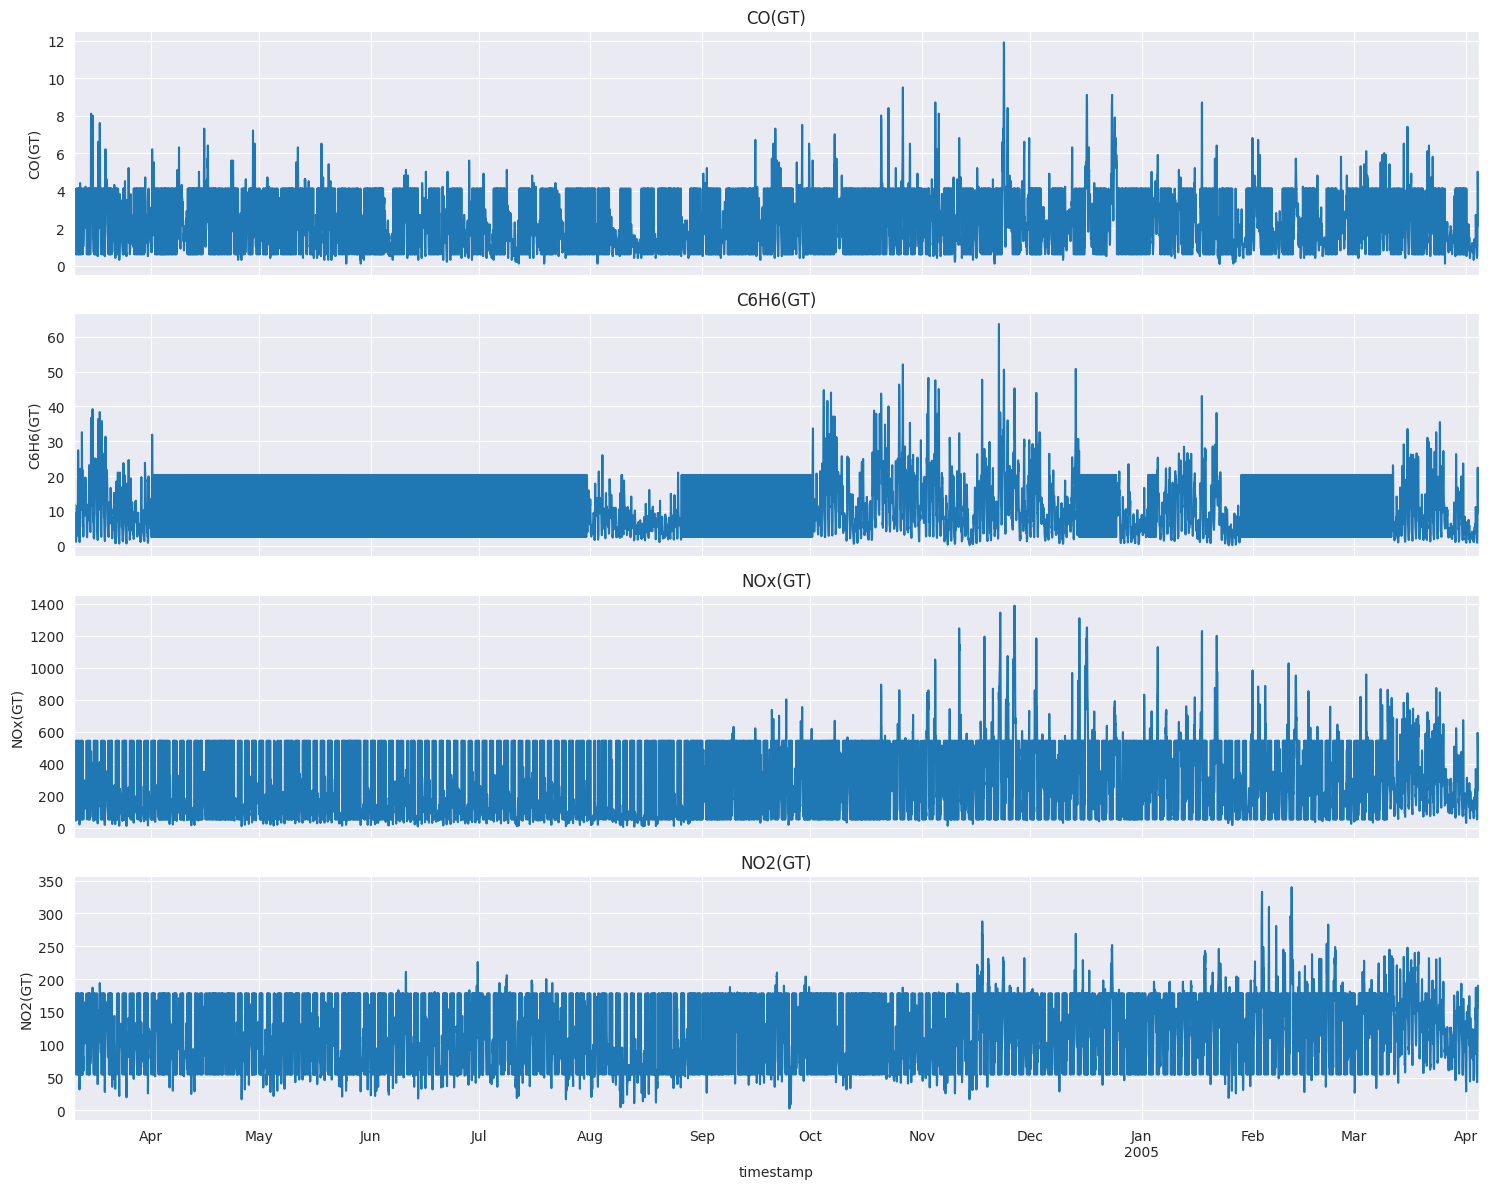

In [19]:
fig, axes = plt.subplots(len(gt_cols), 1, figsize=(15, 3 * len(gt_cols)), sharex=True)
for i, col in enumerate(gt_cols):
    df3[col].plot(ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()

In [20]:
df2.index

DatetimeIndex(['2004-03-10 18:00:00', '2004-03-10 19:00:00',
               '2004-03-10 20:00:00', '2004-03-10 21:00:00',
               '2004-03-10 22:00:00', '2004-03-10 23:00:00',
               '2004-03-11 00:00:00', '2004-03-11 01:00:00',
               '2004-03-11 02:00:00', '2004-03-11 03:00:00',
               ...
               '2005-04-04 05:00:00', '2005-04-04 06:00:00',
               '2005-04-04 07:00:00', '2005-04-04 08:00:00',
               '2005-04-04 09:00:00', '2005-04-04 10:00:00',
               '2005-04-04 11:00:00', '2005-04-04 12:00:00',
               '2005-04-04 13:00:00', '2005-04-04 14:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=9357, freq=None)

In [24]:
tocsv = df2.copy()
tocsv['Date_Time'] = df2.index.strftime('%d/%m/%Y %H.%M.%S')
tocsv.to_csv('AirQuality.csv', index=False) #.iloc[141:]

In [22]:
tocsv.iloc[141:]

CO(GT)  PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
timestamp                                                                    
2004-03-16 15:00:00     2.8       1280.0      14.6         1136.0    180.0   
2004-03-16 16:00:00     2.9       1407.0      16.6         1197.0    184.0   
2004-03-16 17:00:00     2.9       1389.0      15.8         1173.0    190.0   
2004-03-16 18:00:00     3.4       1447.0      17.8         1235.0    184.0   
2004-03-16 19:00:00     3.9       1551.0      19.1         1271.0    181.0   
...                     ...          ...       ...            ...      ...   
2005-04-04 10:00:00     3.1       1314.0      13.5         1101.0    472.0   
2005-04-04 11:00:00     2.4       1163.0      11.4         1027.0    353.0   
2005-04-04 12:00:00     2.4       1142.0      12.4         1063.0    293.0   
2005-04-04 13:00:00     2.1       1003.0       9.5          961.0    235.0   
2005-04-04 14:00:00     2.2       1071.0      11.9         1047.0    265.0   

                     PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T  \
timestamp                                                                     
2004-03-16 15:00:00         893.0    128.0        1675.0       1240.0  27.0   
2004-03-16 16:00:00         905.0    129.0        1759.0       1313.0  28.2   
2004-03-16 17:00:00         898.0    133.0        1739.0       1363.0  28.0   
2004-03-16 18:00:00         859.0    139.0        1778.0       1296.0  23.9   
2004-03-16 19:00:00         800.0    137.0        1875.0       1432.0  21.3   
...                           ...      ...           ...          ...   ...   
2005-04-04 10:00:00         539.0    190.0        1374.0       1729.0  21.9   
2005-04-04 11:00:00         604.0    179.0        1264.0       1269.0  24.3   
2005-04-04 12:00:00         603.0    175.0        1241.0       1092.0  26.9   
2005-04-04 13:00:00         702.0    156.0        1041.0        770.0  28.3   
2005-04-04 14:00:00         654.0    168.0        1129.0        816.0  28.5   

                       RH      AH            Date_Time  
timestamp                                               
2004-03-16 15:00:00  20.2  0.7094  16/03/2004 15.00.00  
2004-03-16 16:00:00  18.6  0.7014  16/03/2004 16.00.00  
2004-03-16 17:00:00  19.1  0.7098  16/03/2004 17.00.00  
2004-03-16 18:00:00  25.7  0.7519  16/03/2004 18.00.00  
2004-03-16 19:00:00  34.8  0.8730  16/03/2004 19.00.00  
...                   ...     ...                  ...  
2005-04-04 10:00:00  29.3  0.7568  04/04/2005 10.00.00  
2005-04-04 11:00:00  23.7  0.7119  04/04/2005 11.00.00  
2005-04-04 12:00:00  18.3  0.6406  04/04/2005 12.00.00  
2005-04-04 13:00:00  13.5  0.5139  04/04/2005 13.00.00  
2005-04-04 14:00:00  13.1  0.5028  04/04/2005 14.00.00  

[9216 rows x 13 columns]